In [5]:
import os
from dotenv import load_dotenv
load_dotenv('../.flaskenv')

True

In [6]:
from pathlib import Path
Home = str(Path.home())

import numpy as np
import pandas as pd

import sys
path = f'{Home}/repos/EPObjects/'
sys.path.insert(0, path)

from probabilistic.probabilistic_parameters import ProbabilisticParameters
from probabilistic.energy_predictions import EnergyPrediction, ProbabilisticEnergyPrediction
from ml_models import get_scaling_layer

from helper.run_period import get_run_periods

from service import db_functions as db

import matplotlib.pyplot as plt

2023-12-20 08:57:02.055386: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-20 08:57:02.109975: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
solid_colors = ['#1f77b4', '#d62728', '#9467bd', '#2ca02c', '#ff7f0e',]
num_solid_colors = len(solid_colors)

def rgb_to_hex(c):
    c = c.astype(np.int16)
    return '#%02x%02x%02x' %(c[0], c[1], c[2])

def hex_to_rg(h):
    return np.array([int(h[i:i+2], base=16) for i in (1, 3, 5)], dtype=np.int16)

def get_weighed_color(col1, col2='#ffffff', w=0.5):
    c1 = hex_to_rg(col1)
    c2 = hex_to_rg(col2)
    return rgb_to_hex((c1 * (1-w)) + (w * c2))

class ColorScale:
    def __init__(self, c1, c2, mi, ma):
        self.Color1 = c1
        self.Color2 = c2
        self.Min = mi
        self.Max = ma
        self.Range = self.Max - self.Min

    def scale(self, value):
        return (value-self.Min)/self.Range
        
    def color(self, value):
        if isinstance(value, np.ndarray):
            vs = []
            for v in value:
                vs.append(get_weighed_color(self.Color1, self.Color2, self.scale(v)))
            return vs
        return get_weighed_color(self.Color1, self.Color2, self.scale(value))

In [8]:
mapping = {
    "u-value:WallExternal": "u-value:Wall\n(W/m\u00b2K)",
    "u-value:FloorGround": "u-value:Floor\n(W/m\u00b2K)",
    "u-value:Roof": "u-value:Roof\n(W/m\u00b2K)",
    "u-value:Window": "u-value:Window\n(W/m\u00b2K)",
    "g-value:Window": "g-value (-)",
    "Permeability": "Peremability\n(m\u00b3/m\u00b2h)",
    "HeatingSP": "Setpoint (C)",
    "HeatingCOP": "Coefficient of\nperformance (-)",
    'Occupancy:Office': "Occupancy\n(Person/m\u00b2)",
    'InternalMass:Office': "Internal Mass\n(W/m\u00b2)", 
    'LightHeatGain:Office': 'Lights\n(W/m\u00b2)',
    'EquipmentHeatGain:Office': 'Equipment\n(W/m\u00b2)'
}

def get_name_mapping(name):
    return mapping.get(name, '-')

In [9]:
user_name = 'tum-gni'
proj_name = 'tausendpfund-ed'

search_conditions = db.get_search_conditions(user_name, proj_name)
pps = db.get_columns(search_conditions, db.PARAMETERS, convert_to_df=True)
pps = ProbabilisticParameters.from_df(pps)
scaling_df_X = pps.get_scaling_df()
scaling_x = get_scaling_layer(scaled_df=scaling_df_X)

consumption_df = db.get_columns(search_conditions, db.CONSUMPTION, True)
run_periods, targets = get_run_periods(consumption_df)

simulation_results = db.get_columns(search_conditions, db.SIMULATION_RESULTS,)
simulation_results = ProbabilisticEnergyPrediction.from_json(simulation_results)
simulation_results = simulation_results.Values['Total']

results = db.get_columns(search_conditions, db.RESULTS,)

combinations = pd.DataFrame.from_dict(results[db.PARAMETERS])
predictions = pd.DataFrame.from_dict(results[db.PREDICTIONS])

scaling_data = db.get_columns(search_conditions, db.SCALING)
scaling_df_Y = pd.DataFrame.from_dict(scaling_data[db.SCALING_DF_Y])
scaling_y = get_scaling_layer(scaled_df=scaling_df_Y)

In [10]:
results

{'PARAMETERS': {'u-value:WallExternal': {'0': 0.19054433703422546,
   '1': 0.19420865178108215,
   '2': 0.19053587317466736,
   '3': 0.19736193120479584,
   '4': 0.19284529983997345,
   '5': 0.19666679203510284,
   '6': 0.19639262557029724,
   '7': 0.19558116793632507,
   '8': 0.18866229057312012,
   '9': 0.19198650121688843},
  'u-value:FloorGround': {'0': 0.18555133044719696,
   '1': 0.19289034605026245,
   '2': 0.1958341747522354,
   '3': 0.19750343263149261,
   '4': 0.19189608097076416,
   '5': 0.19725923240184784,
   '6': 0.19705381989479065,
   '7': 0.19612087309360504,
   '8': 0.18856371939182281,
   '9': 0.18878504633903503},
  'u-value:Roof': {'0': 0.14240320026874542,
   '1': 0.14736288785934448,
   '2': 0.14434398710727692,
   '3': 0.1481039822101593,
   '4': 0.14503984153270721,
   '5': 0.14856691658496857,
   '6': 0.14932242035865784,
   '7': 0.1505831480026245,
   '8': 0.14077946543693542,
   '9': 0.14438970386981964},
  'u-value:Window': {'0': 0.7517671585083008,
   '1':

In [11]:
def plot_multiaxis(ax, pps):
    for i, pp in enumerate(pps):
        ax.plot([i, i], [0, 1], lw=1, ls='--', color='k', zorder=10)
        ax.plot(i * np.ones((6)), np.linspace(0, 1, 6), marker='_', markersize=5, color='#aaaaaa', lw=0.1)
        
        ax.text(i, -0.07, f'{pp.Min:.02f}', size=8, horizontalalignment='center')
        ax.text(i, 1.07, f'{pp.Max:.02f}', size=8, horizontalalignment='center', verticalalignment='top')
        ax.plot([i, i], [-0.01, 1.01], lw=0.5, ls='-.', color='k', zorder=1)


def plot_results_scale(ax, results_pos, error_scale):
    consumption_scale = ColorScale('#bbbbbb', '#ff7f0e', 0, 1.0)
    breaks = 50
    for i, t in enumerate(scaling_df_Y.iterrows()):
        plt.text(results_pos+0.1, i*.25, t[0][:3], horizontalalignment='left', size=8)
        for j in range(breaks):
            ax.plot([results_pos, results_pos], [i*0.25 + j*0.2/breaks, i*0.25 + (j+1) * 0.2/breaks], lw=2, ls='-', color=consumption_scale.color(j/breaks), zorder=1)
            if i==0:
                ax.plot([results_pos+1.5, results_pos+1.5], [i*0.25 + j*0.4/breaks, i*0.25 + (j+1) * 0.4/breaks], lw=2, ls='-', color=consumption_scale.color(j/breaks), zorder=1)
    
    increment = error_scale.Range/breaks
    for j in np.linspace(error_scale.Min, error_scale.Max, breaks):
        y_start = 0.5 + error_scale.scale(j) * 0.4 
        y_end = 0.5 + error_scale.scale(j+increment) * 0.4
        ax.plot([results_pos+1.5, results_pos+1.5], [y_start, y_end], lw=2, ls='-', color=error_scale.color(j), zorder=1)
    # break

    ax.text(results_pos+1.6, 0.5, f'{error_scale.Min:0.0f} %', size=8)
    ax.text(results_pos+1.7, 0.6, f'Difference\nfrom\nMeasured', size=8)
    ax.text(results_pos+1.6, 0.9, f'{error_scale.Max:0.0f} %', size=8)

    ax.text(results_pos+1.6, 0, f'{scaling_df_Y["Min"][0]/1000:.02f} MWh', size=8)
    ax.text(results_pos+1.7, 0.1, f'Annual\nEnergy\nUse', size=8)
    ax.text(results_pos+1.6, 0.4, f'{scaling_df_Y["Max"][0]/1000:.02f}', size=8)


def plot_results(ax, x, y, error_scale, errors, total_error):
    for i, chr in enumerate(x):
        previous = None
        for p, x1 in enumerate(chr):
            if previous is not None:
                ax.plot([previous[0], p], [previous[1], x1], lw=0.5, ls='--', color=error_scale.color(total_error[i]), zorder=-1)
            previous = [p, x1]
        
        for j, t in enumerate(y[i]):
            ax.plot([previous[0], p+1.5], [previous[1], j*0.25 + t], lw=0.5, ls='--', color=error_scale.color(errors[i, j]), zorder=-1)
    return p


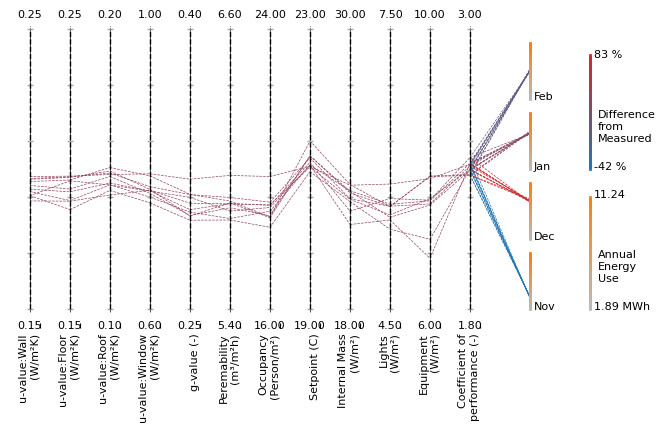

In [12]:
fig, ax = plt.subplots(figsize=(0.5 * len(scaling_df_X) + 2, 4), nrows = 1, ncols = 1)
x = scaling_x(combinations).numpy()
y = scaling_y(predictions).numpy()*0.2

errors = pd.DataFrame.from_dict(results[db.ERRORS]).values
total_error = list(results[db.TOTAL_ERROR].values())

error_scale = ColorScale('#1f77b4', '#d62728', min(errors.min(), min(total_error)), max(errors.max(), max(total_error)))

p = plot_results(ax, x, y, error_scale, errors, total_error)
plot_multiaxis(ax, pps)

results_pos = p+1.5
plot_results_scale(ax, results_pos, error_scale)

xticks = tuple(get_name_mapping(x) for x in pps.get_scaling_df().index)
ax.set_xticks([x+0.25 for x in range(len(xticks))], labels=xticks, size=8, rotation=90, horizontalalignment='right', verticalalignment='top')
ax.set_yticks([])
ax.set_ylim([-0.05, 1.05])
ax.set_xlim([-.5, results_pos+2.5])

ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
plt.grid(False)

plt.savefig(f'{user_name}-{proj_name}-parameters.pdf', bbox_inches='tight')

In [13]:
pps.get_scaling_df().index

Index(['u-value:WallExternal', 'u-value:FloorGround', 'u-value:Roof',
       'u-value:Window', 'g-value:Window', 'Permeability', 'Occupancy:Office',
       'HeatingSP', 'InternalMass:Office', 'LightHeatGain:Office',
       'EquipmentHeatGain:Office', 'HeatingCOP'],
      dtype='object')

In [14]:
pps.get_scaling_df().index

Index(['u-value:WallExternal', 'u-value:FloorGround', 'u-value:Roof',
       'u-value:Window', 'g-value:Window', 'Permeability', 'Occupancy:Office',
       'HeatingSP', 'InternalMass:Office', 'LightHeatGain:Office',
       'EquipmentHeatGain:Office', 'HeatingCOP'],
      dtype='object')

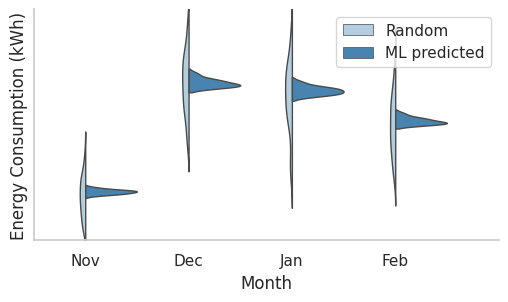

In [15]:
#half violin plots using seaborn graph
#upper values: parameter estimation (in results: simulationdata.values)
#lower values: combinations, last columns
#y1, y2 from Targets (measured values)
import seaborn as sns
sns.set(rc={'figure.figsize':(6,3)})
sns.set_theme(style="whitegrid")

data = pd.DataFrame()
for x, month in enumerate(simulation_results):
  plt.vlines(x, 2.5, 9.5, lw=0.5, color="grey", linestyle = '-.', zorder=-1) 
  
  d1 = pd.DataFrame()
  d1['Energy'] = simulation_results[month]
  d1['Approach'] = 'Random'
  d1['Month'] = month

  d2= pd.DataFrame()
  d2['Energy'] = predictions[month]
  d2['Approach'] = 'ML predicted'
  d2['Month'] = month

  data = pd.concat((data, d1, d2))

ax=sns.violinplot(data=data, width=1, x="Month", y="Energy", hue="Approach", split=True, inner=None, linewidth=1, palette="Blues")

for i, value in enumerate(targets):
    plt.scatter(i, value, marker='_', color='k')
    # plt.text(i, value[x], f' {z}', verticalalignment='center')

plt.xticks(range(len(targets)), [x[:3] for x in scaling_df_Y.index])

plt.ylabel('Energy Consumption (kWh)')
plt.xlim(-0.5, len(targets))
plt.ylim(simulation_results.values.min(), simulation_results.values.max())
plt.grid(axis='y', color='k', linestyle='--', linewidth=0.1)

ax.spines[['right', 'top',]].set_visible(False)
ax.legend(loc = None)#"lower right")
plt.savefig(f'{user_name}-{proj_name}-predictions.pdf', bbox_inches='tight')
plt.show()


In [16]:
targets

,value1
0,6361
1,4722
2,6167
3,6519


In [17]:
# from scipy.stats import norm
# from math import sqrt
# from scipy.stats import t

# import numpy as np
# from numpy.random import seed
# from numpy.random import rand
# from numpy.random import randint
# from numpy import mean
# from numpy import median, mean

# from numpy import percentile

# def ConfidenceIntervalWithoutBS(y):
#     alpha = 5.0
#     lower_p = alpha / 2.0
#     lower = percentile(y, lower_p)
#     upper_p = (100 - alpha) + (alpha / 2.0)
#     upper = percentile(y, upper_p)
#     print (f'{lower:0.02f}-{upper:0.02f}')
#     return lower, upper

# def ConfidenceInterval(y, n=50):
#     seed(1)
#     scores = list()
#     dataset = y
#     samples = len(dataset)
#     for _ in range(n):
#         indices = randint(0, samples, samples)
#         sample = dataset[indices]
#         # calculate and store statistic
#         statistic = sqrt(mean(sample))
#         scores.append(statistic)
    
#     m = mean(scores)
    
#     alpha = 5.0
#     lower_p = alpha / 2.0
#     lower = percentile(scores, lower_p)
#     upper_p = (100 - alpha) + (alpha / 2.0)
#     upper = percentile(scores, upper_p)

#     print (f'{lower:0.02f}-{upper:0.02f}')
#     return lower, upper

In [18]:
# for x, month in enumerate(results):
#   print (month)
#   ConfidenceIntervalWithoutBS(Combinations[f'Predicted_{x}'])
#   ConfidenceIntervalWithoutBS(results[month])

In [19]:
res = scaling_y(targets).numpy() * 0.2

In [20]:
db.get_search_conditions

<function service.db_functions.get_search_conditions(user_name, project_name)>